# 2. Grounded Object Detection

### 2.1 Introduction & Approach

YOLO provided a solid baseline of what can be expected from an object detection model, however, we can do better. One of YOLO's shortcoming was miscategorisation and unknown labels. Solving unknown label is a matter of what data was given to the model whilst it was training, whereas miscategorisation can be fixed.

Since we have access to the prompt, we can extract keywords that were used in it. Let's say our prompt is: "Create a realistic image of a cat and a dog laying down". From this prompt, we recognise 2 object keywords (actions would be a whole different problem on its own) - cat and dog. Now that we have those, we can look specifically for them in our image. Doing so we put another set of constraints on our probabilistic models. If the prompt also include something like *backpack* and we don't find it in the generated image, we could retry.

By taking these steps, we further ensure that our model gets closer to our goal - categorisation and tagging.

### 2.2 Experiment

For this experiment, I'm using [Grounding DINO](https://arxiv.org/abs/2303.05499) which more or less learns to associate words with regions within an image. Where it differs from YOLOv8 is the architecture and training approach. YOLOv8 uses a pre-trained CNN as its backbone and it is trained via supervised training, whereas [DINO](https://arxiv.org/abs/2104.14294) (the backbone of Grounding DINO) utilises a vision transformer architecture and it is trained in a self-supervised fashion.

#### 2.2.1 Preamble

In [1]:
from PIL import Image
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [2]:
IMAGE_PATH = "../assets/meow_and_woof.jpg"
GROUNDING_PROMPT = "dog. cat. backpack."
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

In [3]:
model = load_model(model_config_path="../../models/dino/config/GroundingDINO_SwinT_OGC.py", 
                   model_checkpoint_path="../../models/dino/weights/groundingdino_swint_ogc.pth", 
                   device="cpu"
                  )

/Users/michaelb/Projects/python/image-caption-generator/.venv/lib/python3.10/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


#### 2.2.2 Visualition

/Users/michaelb/Projects/python/image-caption-generator/.venv/lib/python3.10/site-packages/transformers/modeling_utils.py:993: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/michaelb/Projects/python/image-caption-generator/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/Users/michaelb/Projects/python/image-caption-generator/.venv/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


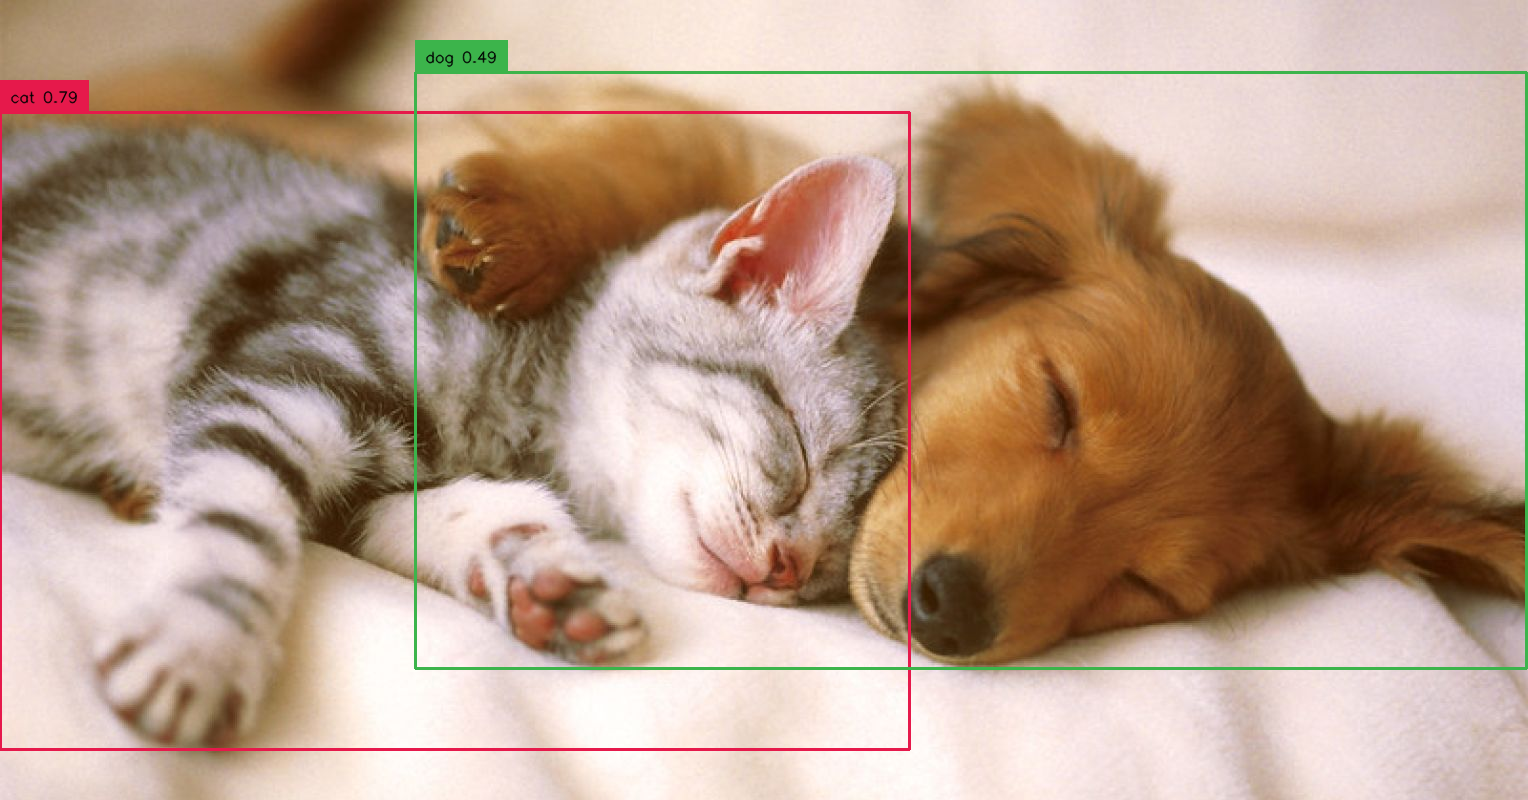

In [4]:
image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=GROUNDING_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device="cpu"
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
Image.fromarray(annotated_frame[..., ::-1])

In this prediction we only get the cat and the dog, despite also providing the extra *backpack* in there.

### 2.3 Conclusion & Next Steps

In conclusion, grounding the detected boxes gives us another layer of confidence in our predictions. For metrics we can use mAP (mean average precision), strict accuracy, or any other metric that would suit our classification problem such as recall, F1, etc.

Based on my assumptions about the prompts and the results coming from this model, I'd say that if constrained object detection and categorisation are the goal, this would be highly viable research venture. However, as with traditional object detection, we still have box boundaries. Assuming an image is inspected first before usage, showing where each predicted category is specifically within an image would be beneficial. Which is why segmentation is a reasonable next step.